# ReLU Me!

Processing an image through a neural network for stylistic effects and education.

---


In [463]:
import json
import datetime
import rangetest
import importlib
import scrapbook
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from sklearn import metrics
import matplotlib.pyplot as plt
from IPython.core import display

importlib.reload(rangetest)
plt.style.use('dark_background')

In [614]:
data_folder = 'data/cat_attack_gray_vsmall/'
layer_sizes = [2] + [50]*10 + [1]
bias_initializer = 'zeros'
batch_norm = "pre"
use_residuals = True

### Run parameters

In [615]:
print({
    'data_folder': data_folder,
    'layer_sizes': layer_sizes,
    'bias_initializer': bias_initializer,
    'batch_norm': batch_norm,
    'use_residuals': use_residuals
})

{'data_folder': 'data/cat_attack_gray_vsmall/', 'layer_sizes': [2, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1], 'bias_initializer': 'zeros', 'batch_norm': 'pre', 'use_residuals': True}


In [616]:
# utils
def mlp_builder(layer_sizes, bias_initializer, batch_norm=None, use_residuals=False):
    """ Creates a feedforward MLP.
    
    We use linear activation at the output and ReLU at hidden layers.
    By default we create a vanilla MLP, but setting the corresponding parameters
    will add batch normalization and/or residual connections to facilitate training
    of deeper nets.
    
    Args:
        layer_sizes (int list): Number of neurons in each layer.
            Note that the first element on this list gives the input size and
            the last element gives the ouput size.
        bias_initializer (string): tf.keras initializer
        batch_norm (string): None (no batch normalization layer),
            "pre" (recommended, before the dense layer),
            "before" (batch normalization applied before the activation),
            "after" (applied after activation)
        use_residuals (bool): Whether to use skip connections.
            Note that skip connections are only used if the input and output dimensions
            of a given hidden layers are the same.
            If not they are simply omitted.
        
    Returns:
        A keras model.
    """
    assert len(layer_sizes)>1, (
        "Network must contain at least an input and output layer")
    assert batch_norm in [None, 'pre', 'before', 'after'], (
        "batch_normalization has incorrect value")
    
    # input layer
    pix_loc = keras.layers.Input(shape=(layer_sizes[0],))
    
    # hidden layers
    layer_input = pix_loc
    for this_width in layer_sizes[1:-1]:
        # place the batch normalization layer
        if batch_norm == 'pre':
            y = keras.layers.BatchNormalization()(layer_input)
        else:
            y = layer_input
            
        y = keras.layers.Dense(this_width, activation=None)(y)
        
        # place the batch normalization layer
        if batch_norm == 'before':
            y = keras.layers.BatchNormalization()(y)
        y = keras.layers.Activation("relu")(y)
        if batch_norm == 'after':
            y = keras.layers.BatchNormalization()(y)
            
        # place the residual connection
        # residual connection is identity -> 
        # can only work between input and output of same dimension
        if use_residuals and (layer_input.shape[1] == this_width):
            layer_input = keras.layers.Add()([layer_input, y])
        else:
            layer_input = y

    # output layer
    color = keras.layers.Dense(layer_sizes[-1], activation=None)(layer_input)

    return keras.models.Model(pix_loc, color)

def viz_history(history, figsize=(9, 9/1.6)):
    """ Visualizes training history.
    
    Args:
       history (dict): Each key should map to a 1D numpy array
           which length is the number of epochs.
       figsize (tuple): Size of the figure.
       
    """
    _, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.plot(history['lr'])
    ax1.set_title('Learning rate schedule')
    ax1.set_ylabel('learning rate')
    ax2.plot(history['loss'])
    ax2.set_title('Loss')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('loss')
    plt.show()
    


In [617]:
# test utils
def test_mlp_builder():
    """ Tests mlp_builder in linear case. """
    test_model = mlp_builder([2, 1], "zeros")
    # compute total number of parameters
    n_weights = 0
    for this_layer in test_model.layers:
        for this_weight in this_layer.get_weights():
            n_weights += np.size(this_weight)
    assert n_weights == 3, "Expected 2 coefficients + 1 bias = 3 parameters"
    
def test_mlp_builder2():
    """ Tests mlp_builder residuals connections. """
    test_model = mlp_builder([2, 2, 2, 1], "zeros")
    test_model_resid = mlp_builder([2, 2, 2, 1], "zeros", use_residuals=True)
    # compute total number of parameters in first model
    n_weights = 0
    for this_layer in test_model.layers:
        for this_weight in this_layer.get_weights():
            n_weights += np.size(this_weight)
    # compute total number of parameters in second model
    n_weights_resid = 0
    for this_layer in test_model_resid.layers:
        for this_weight in this_layer.get_weights():
            n_weights_resid += np.size(this_weight)
    assert n_weights == n_weights_resid, "Residual connections should not add weights"
    
test_mlp_builder()
test_mlp_builder2()

In [618]:
# load information about the transformed data
with open(data_folder+'/meta.json', 'r') as f:
    metadata = json.load(f)
    
# load the img arrays
with np.load(data_folder+'/pic_long.npz') as data:
    pic_long_norm = data['pic_long_norm']
    pix_loc_norm = data['pix_loc_long_norm']
    
height, width, n_channels = metadata['target_size']
n_pixels = height * width
target_size = metadata['target_size']
av_color = np.array(metadata['av_color'])

## Setting up the model and training

---

In [619]:
# clear logs and tf graphs
!rm -rf logs
keras.backend.clear_session()

In [620]:
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
# file_writer.set_as_default()

# class LRTensorBoard(keras.callbacks.TensorBoard):
#     """ This callback saves learning rate to tensorboard.
#     """
#     def __init__(self, log_dir, **kwargs): 
#         super().__init__(log_dir=log_dir, **kwargs)

#     def on_epoch_end(self, epoch, logs=None):
#         logs = logs or {}
#         logs.update({'lr': K.eval(self.model.optimizer.lr)})
#         super().on_epoch_end(epoch, logs)
        
# lr_tensorboard = LRTensorBoard(log_dir)

In [621]:
# building a MLP
model = None
model = mlp_builder(layer_sizes, bias_initializer,
                    batch_norm=batch_norm, use_residuals=use_residuals)
model.compile(
    optimizer=keras.optimizers.Adam(), loss="mse")
# this object will hold the full training history
cumulated_history = {
    'loss': [],
    'lr': [],
    'batch': []
}

### Model architecture

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2)            8           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           150         batch_normalization[0][0]        
__________________________________________________________________________________________________
activation (Activation)         (None, 50)           0           dense[0][0]                      
______________________________________________________________________________________________

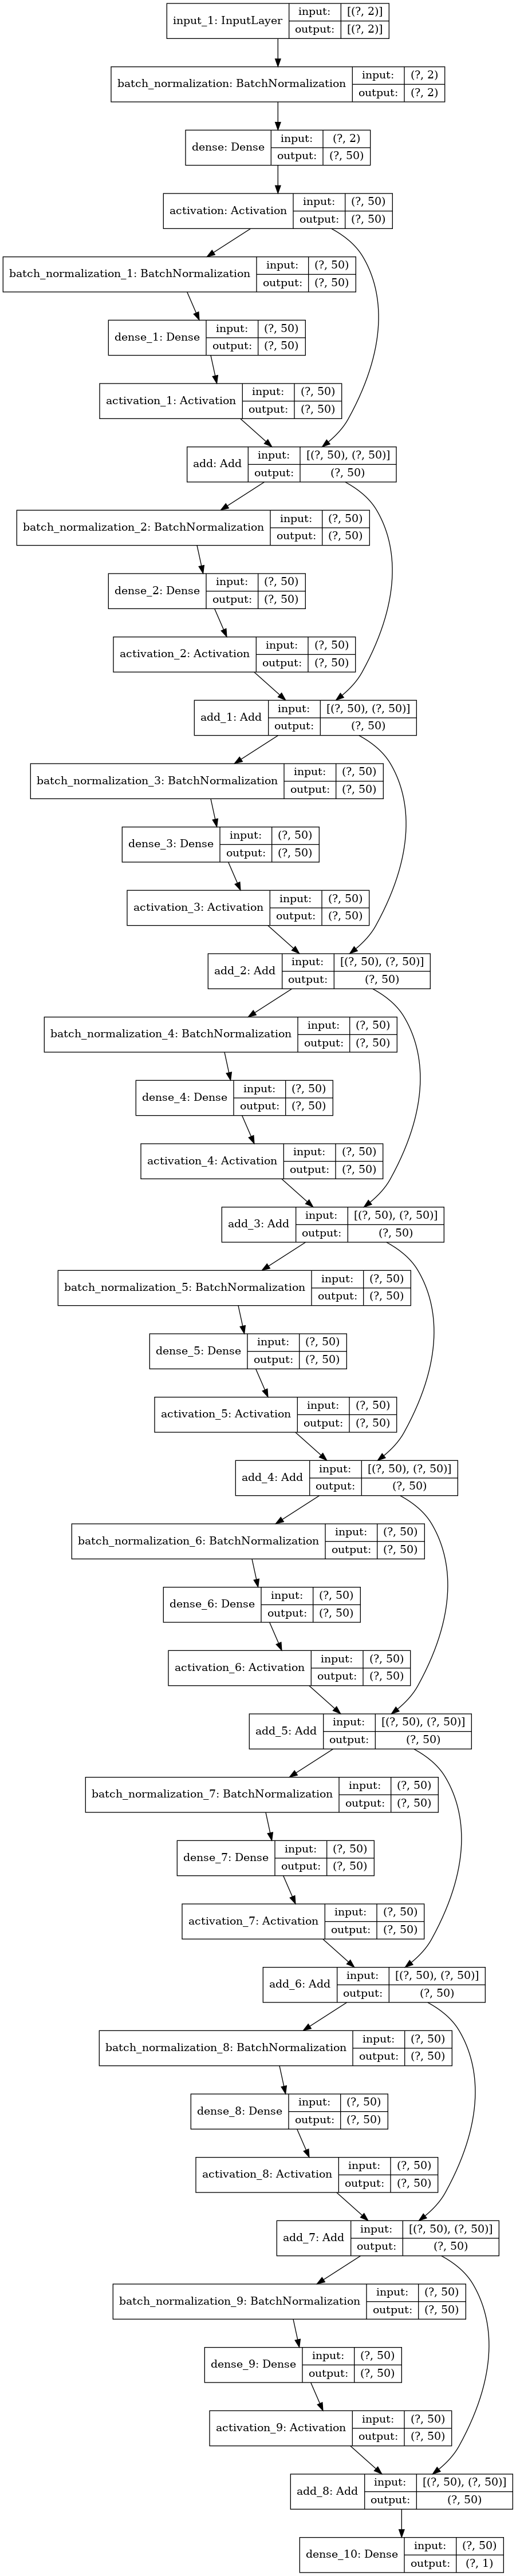

In [622]:
print(model.summary())
keras.utils.plot_model(model, show_shapes=True)

### Optimizer setting

In [623]:
print('Optimizer:', model.optimizer.__class__.__name__)
print(model.optimizer.get_config())

Optimizer: Adam
{'name': 'Adam', 'learning_rate': 0.001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


### Learning rate range test

In [624]:
batch_size = n_pixels // 1
print("Batch size:", batch_size)
print("Number of batches:", (n_pixels // batch_size) + n_pixels % batch_size)

Batch size: 850
Number of batches: 1


In [628]:
range_test = rangetest.lr_range_test(model, pix_loc_norm, pic_long_norm,
             base_lr=0.000001, max_lr=0.1, n_steps=200, batch_size=batch_size)


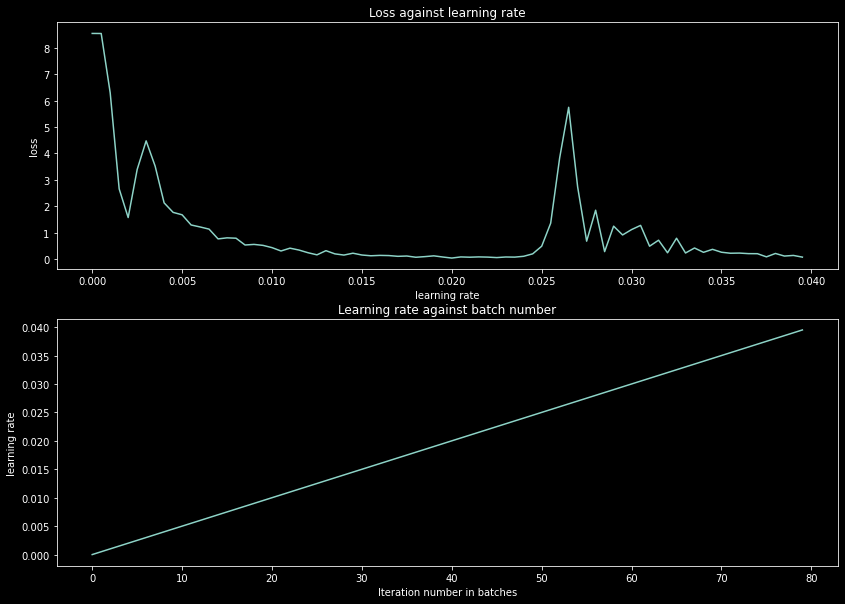

In [631]:
rangetest.show_lr_range_test(range_test, head=80, figsize=(14, 10))
# scrapbook.glue("lr_range_test", range_test, display=True)

In [632]:
clr = rangetest.CyclicLR(base_lr=0.001, max_lr=0.01, step_size=250*n_pixels // batch_size, mode="triangular2")
keras_history = model.fit(
    pix_loc_norm, pic_long_norm, epochs=1000, batch_size=batch_size,
    callbacks=[clr], verbose=0, shuffle=True
    )

### Training curves

In [633]:
for k in cumulated_history:
    cumulated_history[k] += clr.history[k]
    
history_df = pd.DataFrame(cumulated_history)
# history_df = pd.DataFrame(clr.history)
history_df['epoch'] = np.cumsum(history_df.batch.values == 0)
history_df = history_df.groupby('epoch').mean().reset_index()

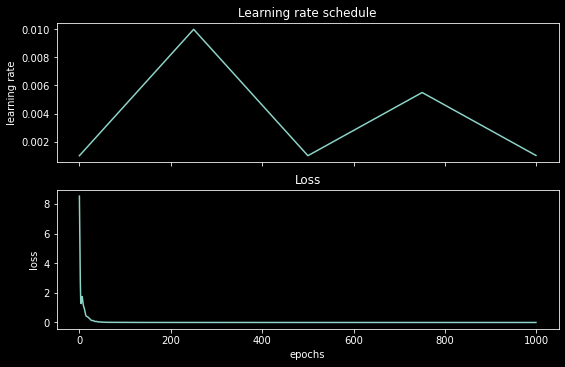

In [634]:
# viz_history(clr.history)
viz_history(dict(history_df))

## Analyze model results

---


In [635]:
# compute the learned image
pred_long = model.predict(pix_loc_norm)

In [636]:
pred_long = model(pix_loc_norm.astype('float32'), training=True).numpy()

### Metrics

In [637]:
model_metrics = pd.DataFrame({
    'naive mse': metrics.mean_squared_error(
        pic_long_norm, np.zeros_like(pic_long_norm)
    ),
    'mse': metrics.mean_squared_error(pic_long_norm, pred_long),
    'naive mae': metrics.mean_absolute_error(
        pic_long_norm, np.zeros_like(pic_long_norm)
    ),
    'mae': metrics.mean_absolute_error(pic_long_norm, pred_long),
    'best_loss': np.min(clr.history['loss'])
    }, index=['value'])

with pd.option_context('precision', 3):
    display.display(display.HTML(model_metrics.to_html()))

In [638]:
print("MSE improvement (%) over naive:",
      ((model_metrics['mse'] - model_metrics['naive mse']) 
      / model_metrics['naive mse']).value)

MSE improvement (%) over naive: -0.9973225


### Reconstructed image

In [639]:
image.array_to_img(255*pred_long.reshape(target_size)+av_color[np.newaxis,:])

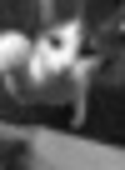

In [640]:
pil= image.array_to_img(255*pred_long.reshape(target_size)+av_color[np.newaxis,:])
pil.resize(size=(width*5, height*5))

### Network gradients

In [641]:
# compute the gradients
x_input = tf.convert_to_tensor(pix_loc_norm, dtype='float32')
with tf.GradientTape() as tape:
    tape.watch(x_input)
    y = model(x_input)
grad = tape.gradient(y, x_input)

In [642]:
print("Number of unique gradients:", np.size(np.unique(grad.numpy(), axis=0)))
print("unique gradients Y direction:", np.size(np.unique(grad.numpy()[:, 0])))
print("unique gradients X direction:", np.size(np.unique(grad.numpy()[:, 1])))

Number of unique gradients: 1700
unique gradients Y direction: 850
unique gradients X direction: 850


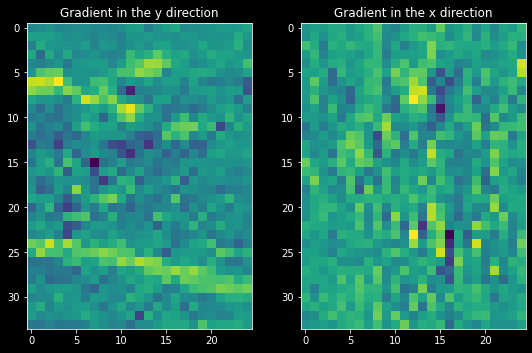

In [643]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 9/1.6))
ax1.imshow(grad.numpy().reshape(height, width, 2)[:,:,0])
ax1.set_title("Gradient in the y direction")
ax2.imshow(grad.numpy().reshape(height, width, 2)[:,:,1])
ax2.set_title("Gradient in the x direction")
None

In [644]:
now = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d-%H:%M")
model_name = '50x10-BN-resid-[{}]'.format(now)
model.save(model_name)
print("Model saved to:", model_name)

INFO:tensorflow:Assets written to: 50x10-BN-resid-[2020-04-15-18:31]/assets
Model saved to: 50x10-BN-resid-[2020-04-15-18:31]


In [645]:
!jupyter nbconvert "ReLU-me.ipynb" --no-input --to markdown --output "50x10-BN-resid.md"

[NbConvertApp] Converting notebook ReLU-me.ipynb to markdown
[NbConvertApp] Support files will be in 50x10-BN-resid_files/
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Making directory 50x10-BN-resid_files
[NbConvertApp] Writing 12230 bytes to 50x10-BN-resid.md
